In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

In [78]:
# import technology table
def return_technology():
    technology = pd.read_csv(f'./../data/technology.csv')
    return technology

In [79]:
# import technology tax data
def return_techtax(scenario):
    tech_tax = pd.read_excel(f'./../TEAM-Kenya_data_out/scenarios/Policy_Step1_TechnologyTax{scenario}.xlsx')
    return tech_tax

In [80]:
# import vehicle stock data from interface
def return_vehstock(scenario):
    veh_stock = pd.read_excel(f'./../scenarios/data-out/{scenario}/Interface_VSM_NumVeh.xlsx')  
    return veh_stock

In [81]:
years = range(2015, 2051)
scenarios = ['OMOKA', 'ELECTRICDREAMS', 'KUJINAO', 'STREETFIGHTING']

technology = return_technology()
veh_types = technology.VehTypeID.unique().tolist()

taxation_by_scenario = {}

for scenario in scenarios:

    tech_tax = return_techtax(scenario)
    veh_stock = return_vehstock(scenario)
    
    taxation = []
    
    for year in years:
        
        taxation_year = {}
        
        for veh_type in veh_types:
            
            # return techIDs corresponding to this veh type available in this year
            techIDs = technology[(technology['Availability'] <= year) & (technology['Final_Year'] >= year) & (technology['VehTypeID'] == veh_type)].TechID.tolist()
            
            # for each techID, return total taxation received: purchase tax * sales
            total_taxation = 0
            for techID in techIDs:
                
                veh_sales = veh_stock[(veh_stock['Year'] == year) & (veh_stock['VehCatID'] == 'N') & (veh_stock['TechID'] == techID)].NumVeh.sum()
                
                purchase_tax = tech_tax[(tech_tax['Year'] == year) & (tech_tax['TechID'] == techID)].PurchaseTax.item()
                
                total_taxation += veh_sales * purchase_tax  # GBP
                
            taxation_year[veh_type] = total_taxation
            
        taxation.append(taxation_year)
        
    taxation_by_scenario[scenario] = taxation

In [82]:
chart_data = {}
for scenario in scenarios:
    series = []
    for t in taxation_by_scenario[scenario]:
        series.append(sum(t.values()) * 150 * 1e-9)  # GBP --> KES bn. using 150 KES == 1 GBP. more stable exchange rate
        
    chart_data[scenario] = series


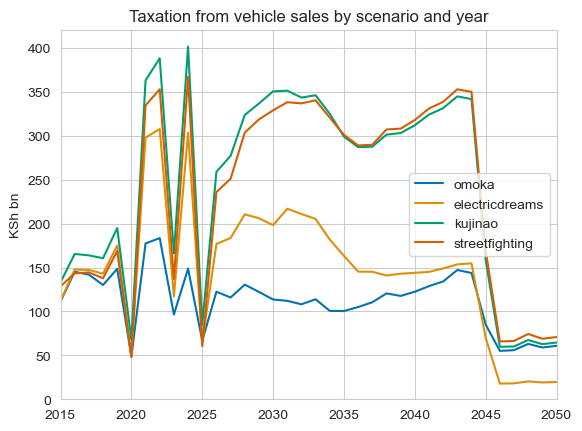

In [83]:
fig, ax = plt.subplots()
clrs = sns.color_palette('colorblind')

cnt = 0
for scenario in scenarios:
    ax.plot(range(2015, 2051), chart_data[scenario], color=clrs[cnt], label=scenario.lower())
    
    cnt += 1
    
ax.legend()
ax.set_ylabel('KSh bn')
ax.set_ylim(bottom=0)
ax.set_xlim(left=2015, right=2050)
ax.set_title('Taxation from vehicle sales by scenario and year')

plt.savefig('vehicle-sales-tax.pdf')